# Batch correction (Reanalysis of Stadler et al, 2025)

In large-scale proteomics experiments, samples are often processed in multiple batches (in different plates, at multiple days, or in different instrument runs). These technical variations can introduce systematic biases that might overshadow the biological signals we're trying to detect. This tutorial demonstrates how to identify and correct these batch effects using the `alphatools` package.


We use data from a recent study by Stadler et al. (2025) which analyzed 96 patient samples from 5 different inflammatory skin diseases that lead to skin rashs and redening (*erythroderma*). The proteomics data was generated across two processing plates which lead to observable batch effects. Here, we identify and correct for this confounder using the `alphatools` methods, which is essential to obtain a better understanding of the underlying biological variation between the conditions.


> Note that until publication of the study, the data used in this tutorial is not available. Upon publication, the data will be made accessible to users in the package.

This notebook demonstrates:
1. How to identify batch effects in proteomics data
2. How to correct for batch effects using ComBat
3. How to quantitatively assess the success of batch correction using Principal Component Regression (PCR)

**References**

[1] 1. Stadler, P.-C. et al. Multi-Omics Molecular Profiling Enables Rapid Diagnosis of Erythrodermic Skin Diseases. 2025.09.12.25335624 Preprint at https://doi.org/10.1101/2025.09.12.25335624 (2025).

[2] W. Evan Johnson, Cheng Li, and Ariel Rabinovic. Adjusting batch effects in microarray expression data using empirical bayes methods. Biostatistics, 8(1):118–127, apr 2006. URL: https://doi.org/10.1093/biostatistics/kxj037, doi:10.1093/biostatistics/kxj037.


In [ ]:
import alphatools as at
import matplotlib.pyplot as plt
import pandas as pd

## Read diann report into anndata

First, we load the proteomics data with alphatools that was generated with the DIANN search engine. For more details, see the reader tutorial. 

In [ ]:
adata = at.io.read_pg_table("./data/stadler2025_report.pg_matrix.tsv", search_engine="diann")
adata

AnnData object with n_obs × n_vars = 96 × 9719
    var: 'uniprot_ids', 'genes', 'protein_candidates', 'description'

## Add metadata 

We combine the proteomics data with the available patient level metadata. 

In [ ]:
metadata = pd.read_csv("./data/stadler2025_metadata.tsv", sep="\t", index_col="sample_path")

adata = at.pp.add_metadata(adata, incoming_metadata=metadata, axis=0)
adata.obs

,patient_id,sample_name,plate,position,patient_idx,disease_label
U:\PiaStadler\Plate7_Erythrodermia_Val\20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2000V_ISDA_P003_Plate7_Position01_eAD_11.raw,AD_11,20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate7,Position01,11,AD
U:\PiaStadler\Plate7_Erythrodermia_Val\20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2000V_ISDA_P003_Plate7_Position02_PRP_15.raw,PRP_15,20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate7,Position02,15,PRP
U:\PiaStadler\Plate7_Erythrodermia_Val\20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2000V_ISDA_P003_Plate7_Position03_MF_16.raw,CTCL_16,20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate7,Position03,16,CTCL
U:\PiaStadler\Plate7_Erythrodermia_Val\20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2000V_ISDA_P003_Plate7_Position04_ePSO_17.raw,Pso_17,20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate7,Position04,17,Pso
U:\PiaStadler\Plate7_Erythrodermia_Val\20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2000V_ISDA_P003_Plate7_Position05_MPE_19.raw,MPR_19,20240119_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate7,Position05,19,MPR
...,...,...,...,...,...,...
U:\PiaStadler\Plate1_Erythroderm\20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2400V_ISDA_Plate1_Position07_MPE_11.raw,MPR_11,20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate1,Position07,11,MPR
U:\PiaStadler\Plate1_Erythroderm\20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2400V_ISDA_Plate1_Position06_MF_03.raw,CTCL_03,20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate1,Position06,3,CTCL
U:\PiaStadler\Plate1_Erythroderm\20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2400V_ISDA_Plate1_Position05_AD_02.raw,AD_02,20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate1,Position05,2,AD
U:\PiaStadler\Plate1_Erythroderm\20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F40_2400V_ISDA_Plate1_Position03_MF_02.raw,CTCL_02,20230921_OA3_ThNo_SA_N756_4Th5ms_Evo01_21min_F...,Plate1,Position03,2,CTCL


## Quality control

For quality control, we follow the original publication and filter for a minimal feature completeness of 75% (maximally 25% missing values) across all samples. 

To be able to reconstruct the individual steps at the end, we store the intermediate results in the `anndata.AnnData.layers` attribute.

In [ ]:
adata = at.pp.filter_data_completeness(adata, max_missing=0.25)
adata.layers["raw"] = adata.X.copy()
adata

INFO:root:pp.filter_data_completeness(): Dropped 4484 / 9719 features with >0.25 missing in any group.


AnnData object with n_obs × n_vars = 96 × 5235
    obs: 'patient_id', 'sample_name', 'plate', 'position', 'patient_idx', 'disease_label'
    var: 'uniprot_ids', 'genes', 'protein_candidates', 'description'
    layers: 'raw'

## Preprocessing

The data gets log transformed to stabilized the variance and reduce the value range.

In [ ]:
adata = at.pp.nanlog(adata, base=2)
adata.layers["log2"] = adata.X.copy()

The data is subsequently median imputed. Note that median imputation assumes that the values are missing at random, i.e. that there is not, for example, a strong dependence of the missingness on the protein intensity. For this approach, it is therefore important to remove features that exhibit a very high missingness for which this assumption is likely not met. 

In [ ]:
adata = at.pp.impute_median(adata)
adata.layers["median_imputed"] = adata.X.copy()

## PCA/exploration of batch effects 
To get an overview over the data, we run a principal component analysis and plot the samples in a PCA plot

In [ ]:
adata = at.pp.pca(adata)

INFO:alphatools.pp.embeddings:computing PCA


When we run a PCA on the median imputed data, we observe very strong batch effects between the two processing plates. The batches are clearly separated along the second principal component

INFO:root:Column 'plate' found in: data.obs.columns. Using that
INFO:root:Column 'plate' found in: data.obs.columns. Using that
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/pl/colors.py:215: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:


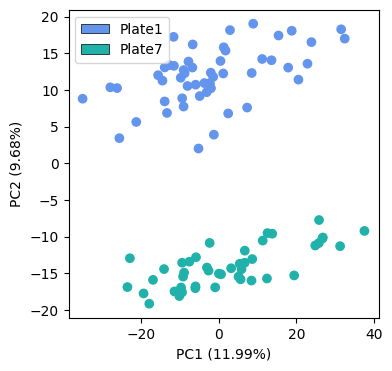

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

at.pl.Plots.plot_pca(
    adata,
    ax=ax,
    color_map_column="plate",
    palette=["#6495ED", "#20B2AA"],
    legend="auto",
)

### Batch correction

To mitigate these technical artifacts, `alphatools` implements batch correction strategies such as PyCombat. You can easily call the tool with the `at.pp.scanpy_pycombat` function, which leverages the `scanpy` implementation of the combat algorithm. 

In [ ]:
adata = at.pp.scanpy_pycombat(adata, batch="plate")
adata.layers["combat"] = adata.X.copy()

INFO:alphatools.pp.batch_correction: scanpy_pycombat: pply pyComBat to correct for plate
... storing 'plate' as categorical
... storing 'position' as categorical
... storing 'disease_label' as categorical
... storing 'genes' as categorical


Batch correction can be important to remove technical artifacts in the data. However, you also risk to *overcorrect* your data and remove true biological signals. We will evaluate further whether we were able to retain the biological signal after running pycombat

## Evaluation of batch correction 

Let's now explore how well pyCombat removed the batch effects in the data. We can again use the visual inspection via a PCA plot. Additionally, however, we will quantify the reduction of the batch effect with a metric called **principal component regression** (PCR).


### PCR
**PCR** quantifies how much of the variation in your data is explained by a specific factor (e.g., batch or disease). Think of it as a way to measure how strongly a particular variable influences the overall structure of your dataset.

The method operates in three steps. First, for each principal component (PC), it calculates the correlation between that PC and your factor of interest. Second, it weights this correlation by the amount of total variance that PC explains in the dataset. Finally, it sums these weighted correlations across all PCs to produce a single metric. 

When PCR is close to 0, it indicates that the factor has little influence on the overall data structure. Conversely, values approaching 1 suggest that the factor strongly drives the main patterns in your data. In the context of batch correction assessment, you expect to see high PCR values for batch effects before correction, indicating that technical variation dominates the data structure. After successful correction, the PCR for batch should drop substantially, although there is also no universal threshold for what constitutes "acceptable" batch effects. Meanwhile, the PCR for biological factors should remain stable or even increase, confirming that the biological signal has been preserved.

There are some caveats when using principal component regression. The method assumes linear relationships between factors and PCs, which means it may miss complex, non-linear batch effects. For more info, checkout the original publications that suggested the metric for the assessment of batch effects in (single cell RNAseq) omics data. 


- Luecken, M.D., Büttner, M., Chaichoompu, K. et al. Benchmarking atlas-level data integration in single-cell genomics. Nat Methods 19, 41-50 (2022). https://doi.org/10.1038/s41592-021-01336-8
- Büttner, M., Miao, Z., Wolf, F.A. et al. A test metric for assessing single-cell RNA-seq batch correction. Nat Methods 16, 43-49 (2019). https://doi.org/10.1038/s41592-018-0254-1

Now, we compute the PCA on the uncorrected and batch corrected data: 

In [ ]:
adata = at.pp.pca(adata, layer="median_imputed", embbedings_name="X_pca__median_imputed")
adata = at.pp.pca(adata, layer="combat", embbedings_name="X_pca__combat")

INFO:alphatools.pp.embeddings:computing PCA
INFO:alphatools.pp.embeddings:computing PCA


We can compute the PCR for the main batch covariate (`plate`) as well as the expected biological driver (`disease_label`)

In [ ]:
pca_keys = ("X_pca__median_imputed", "X_pca__combat")

explained_variance_batch = {
    pca_name: at.metrics.principal_component_regression(
        adata, covariate="plate", pca_key=pca_name, pca_key_uns=pca_name
    )
    for pca_name in pca_keys
}
explained_variance_bio = {
    pca_name: at.metrics.principal_component_regression(
        adata, covariate="disease_label", pca_key=pca_name, pca_key_uns=pca_name
    )
    for pca_name in pca_keys
}

/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/metrics/_principal_component_regression.py:150: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(y):
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/metrics/_principal_component_regression.py:150: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(y):
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/metrics/_principal_component_regression.py:150: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categori

Visual inspection shows that pycombat was able to remove most of the batch effects. This is also confirmed by the reduced explained variance that is explained by the batch in the data. 

INFO:root:Column 'plate' found in: data.obs.columns. Using that
INFO:root:Column 'plate' found in: data.obs.columns. Using that
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/pl/colors.py:215: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:
INFO:root:Column 'plate' found in: data.obs.columns. Using that
INFO:root:Column 'plate' found in: data.obs.columns. Using that
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/pl/colors.py:215: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:


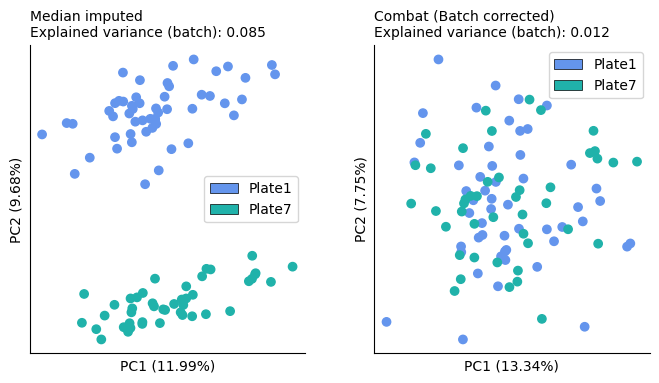

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0.25})

for name, pca_name, ax in zip(["Median imputed", "Combat (Batch corrected)"], pca_keys, axs.ravel(), strict=False):
    at.pl.Plots.plot_pca(
        adata,
        embbedings_name=pca_name,
        ax=ax,
        color_map_column="plate",
        palette=["#6495ED", "#20B2AA"],
        legend="auto",
    )

    ax.set_title(
        f"{name}\nExplained variance (batch): {abs(explained_variance_batch[pca_name]):.3f}", loc="left", fontsize=10
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["top", "right"]].set_visible(False)

plt.show()

On the other hand, the biological variation remained stable between uncorrected and corrected data and the groups seem visually similarly separated. This suggests that the algorithm probably did not overcorrect the data. 

INFO:root:Column 'disease_label' found in: data.obs.columns. Using that
INFO:root:Column 'disease_label' found in: data.obs.columns. Using that
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/pl/colors.py:215: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:
INFO:root:Column 'disease_label' found in: data.obs.columns. Using that
INFO:root:Column 'disease_label' found in: data.obs.columns. Using that
/Users/lucas-diedrich/Documents/Projects/scverse/alphatools/programming/alphatools/src/alphatools/pl/colors.py:215: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:


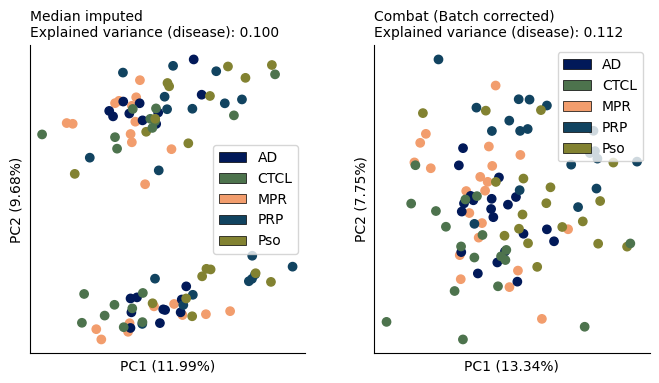

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0.25})

for name, pca_name, ax in zip(["Median imputed", "Combat (Batch corrected)"], pca_keys, axs.ravel(), strict=False):
    at.pl.Plots.plot_pca(
        adata,
        embbedings_name=pca_name,
        ax=ax,
        color_map_column="disease_label",
        legend="auto",
    )

    ax.set_title(
        f"{name}\nExplained variance (disease): {abs(explained_variance_bio[pca_name]):.3f}", loc="left", fontsize=10
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["top", "right"]].set_visible(False)

plt.show()

## Write 
If you'd like to continue working with your anndata object, you can write it to disk

In [ ]:
# adata.write_h5ad("./data/stadler2025.h5ad")

## Summary: Key Takeaways
 
**Batch effects are common** in proteomics and can mask biological signals. Alphatools supports users in investigating, quantifying, and removing batch effects.
 
**Always validate batch correction** with multiple approaches (visual + quantitative via principal component regression and other metrics, e.g. as implemented in the [scIB package](https://scib.readthedocs.io/en/latest/))

**Consider the limitations** of both ComBat and PCR when interpreting results